### Necessary Packages

In [1]:
import torch
import numpy as np
import sys
import dotenv
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../..')
from timm.models import VisionTransformer
from timm.data import resolve_model_data_config,create_transform
from torchsummary import summary
from torch.utils.data import DataLoader
from src.transforms import LabelMapper
from src.utils import load_model_from_folder,load_history_from_folder,predict,create_df,make_metric,compute_metrics
from src.datasets import RoIDataset
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score


Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/projet/.env.
Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/projet/.env.


**Model Hyperparameters :**

- Initial weights : https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights/dino_vit_small_patch16_ep200.torch.
- batch size : 32
- epochs : 3
- learning rate : 0.0001
- sampler : balanced
- decay rate : no learning rate decay
- dropout : no dropout
- optimizer : adam
- weight decay : 0.00001
- Depth : The whole network is trained.

### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Results reproducibility

In [3]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

### Load envirement variables

In [4]:
PATCHES_DIR = dotenv.get_key(dotenv.find_dotenv(), "PATCHES_DIR")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "HISTORIES_DIR")

In [5]:
TRAIN_DIR = os.path.join(PATCHES_DIR, "train")
VAL_DIR = os.path.join(PATCHES_DIR, "val")
TEST_DIR = os.path.join(PATCHES_DIR, "test")

In [6]:
print(MODELS_DIR)
print(PATCHES_DIR)
print(HISTORIES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)
print(TEST_DIR)

/home/abdelnour/Documents/4eme_anne/S2/projet/models
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched
/home/abdelnour/Documents/4eme_anne/S2/projet/histories
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/train
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/val
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/test


### Global

In [7]:
BATCH_SIZE = 512
NUM_WORKERS = 6
PREFETCH_FACTOR = 2
WEIGHTS_FOLDER  = os.path.join(MODELS_DIR, "vit")
HISTORIES_FOLDER = path = os.path.join(HISTORIES_DIR, "vit")

### Load the model

In [8]:
model = VisionTransformer(img_size=224,patch_size=16,num_heads=6,embed_dim=384,num_classes=3).to(device)

In [9]:
load_model_from_folder(model, WEIGHTS_FOLDER, verbose=True)

loading weights with name : 1714429524.0255542.pt


In [10]:
summary(model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
           Dropout-4             [-1, 197, 384]               0
          Identity-5             [-1, 197, 384]               0
          Identity-6             [-1, 197, 384]               0
         LayerNorm-7             [-1, 197, 384]             768
            Linear-8            [-1, 197, 1152]         443,520
          Identity-9           [-1, 6, 197, 64]               0
         Identity-10           [-1, 6, 197, 64]               0
           Linear-11             [-1, 197, 384]         147,840
          Dropout-12             [-1, 197, 384]               0
        Attention-13             [-1, 197, 384]               0
         Identity-14             [-1, 1

### Learning graph

In [11]:
history_df = load_history_from_folder(HISTORIES_FOLDER)

<Axes: xlabel='epoch', ylabel='accuracy'>

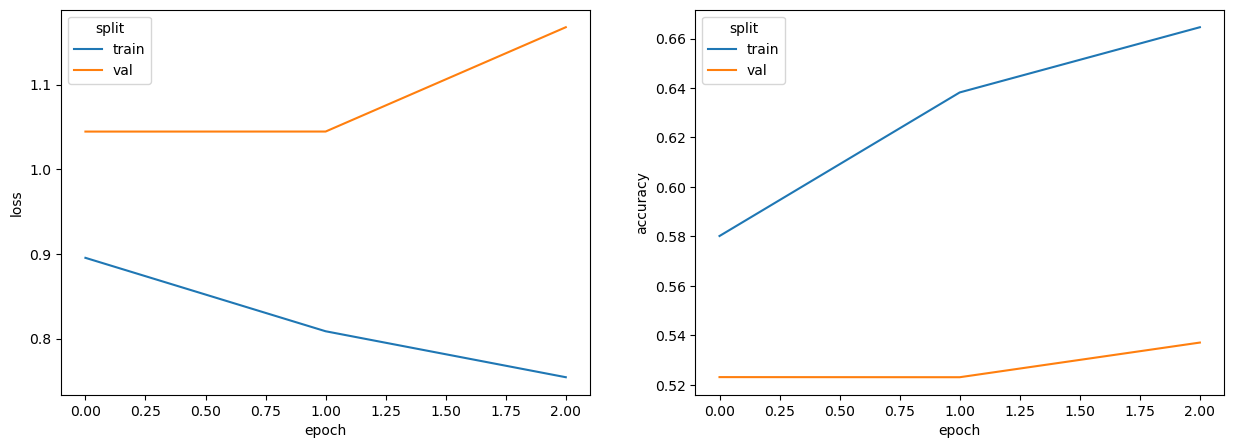

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.set_size_inches(15, 5)

sns.lineplot(data=history_df, x="epoch", y="loss", hue="split", ax=ax1)
sns.lineplot(data=history_df, x="epoch", y="accuracy", hue="split", ax=ax2)

### Data Loading

In [13]:
label_mapper = LabelMapper({
    0:0, # 0 is the label for benign (BY)
    1:0, 
    2:0,
    3:1, # 1 is the label for atypical (AT)
    4:1,
    5:2, # 2 is the label for malignant (MT)
    6:2,
})

In [14]:
data_config = resolve_model_data_config(model)
transform = create_transform(**data_config, is_training=False)

In [15]:
dataset = RoIDataset(
    root=TEST_DIR,
    target_transform=label_mapper,
    transform=transform,
)

In [16]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

### Prediciting

In [17]:
paths,y_hat,y = predict(model, loader, device=device)

  0%|          | 0/78 [00:00<?, ?it/s]

In [18]:
df = create_df(paths,y, y_hat)

In [19]:
df.head()

,patch_name,label,roi,benign,atypical,malignant,predicted_label
0,BRACS_1286_N_40_0.png,0,BRACS_1286_N_40.png,0.659312,0.196448,0.144239,0
1,BRACS_1286_N_40_1.png,0,BRACS_1286_N_40.png,0.849197,0.103979,0.046824,0
2,BRACS_1286_N_40_10.png,0,BRACS_1286_N_40.png,0.610991,0.300331,0.088678,0
3,BRACS_1286_N_40_11.png,0,BRACS_1286_N_40.png,0.715324,0.218249,0.066427,0
4,BRACS_1286_N_40_12.png,0,BRACS_1286_N_40.png,0.811201,0.113276,0.075523,0


### Predictions analysis (patches persepective)

In [20]:
metrics= {
    "accuracy" : accuracy_score,
    "precision_macro" : make_metric(precision_score, average="macro"),
    "precision_micro" : make_metric(precision_score, average="micro"),
    "recall_macro" : make_metric(recall_score, average="macro"),
    "recall_micro" : make_metric(recall_score, average="micro"),
    "f1_macro" : make_metric(f1_score, average="macro"),
    "f1_micro" : make_metric(f1_score, average="micro")
}

In [21]:
compute_metrics(metrics, df["label"], df["predicted_label"])

accuracy           0.536499
precision_macro    0.517619
precision_micro    0.536499
recall_macro       0.501101
recall_micro       0.536499
f1_macro           0.474868
f1_micro           0.536499
dtype: float64

<Axes: >

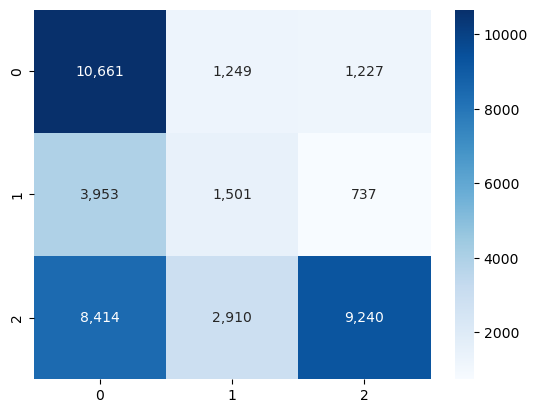

In [22]:
cm = confusion_matrix(df["label"], df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, softvoting)

In [23]:
soft_df = df[["label","roi","benign","atypical","malignant"]] \
    .groupby(by=["label","roi"]) \
    .mean() \
    .reset_index()

In [24]:
soft_df.head()

,label,roi,benign,atypical,malignant
0,0,BRACS_1228_UDH_2.png,0.208189,0.657590,0.134221
1,0,BRACS_1284_UDH_4.png,0.543640,0.309238,0.147122
2,0,BRACS_1286_N_40.png,0.585970,0.273323,0.140707
3,0,BRACS_1286_PB_21.png,0.594927,0.258426,0.146647
4,0,BRACS_1286_PB_5.png,0.620700,0.243650,0.135650


In [25]:
soft_df["predicted_label"] = np.argmax(soft_df[['benign','atypical','malignant']].values, axis=1)

In [26]:
soft_df.head()

,label,roi,benign,atypical,malignant,predicted_label
0,0,BRACS_1228_UDH_2.png,0.208189,0.657590,0.134221,1
1,0,BRACS_1284_UDH_4.png,0.543640,0.309238,0.147122,0
2,0,BRACS_1286_N_40.png,0.585970,0.273323,0.140707,0
3,0,BRACS_1286_PB_21.png,0.594927,0.258426,0.146647,0
4,0,BRACS_1286_PB_5.png,0.620700,0.243650,0.135650,0


In [27]:
compute_metrics(metrics, soft_df["label"], soft_df["predicted_label"])

accuracy           0.568421
precision_macro    0.581389
precision_micro    0.568421
recall_macro       0.521714
recall_micro       0.568421
f1_macro           0.517701
f1_micro           0.568421
dtype: float64

<Axes: >

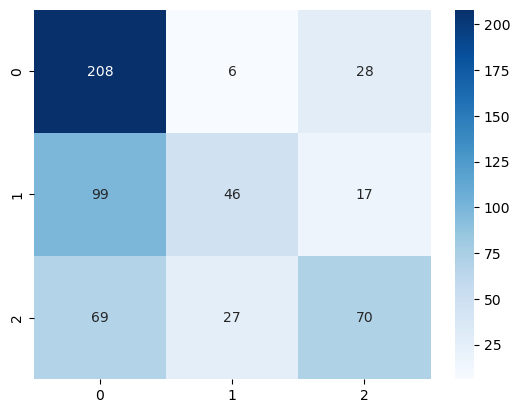

In [28]:
cm = confusion_matrix(soft_df["label"], soft_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, hardvoting)

In [29]:
def count(x:np.ndarray) -> float:
    values, counts = np.unique(x, return_counts=True)
    return values[counts.argmax()]


In [30]:
hard_df = df[["label","roi","predicted_label"]] \
    .groupby(by=["label","roi"]) \
    .agg(count) \
    .reset_index()

In [31]:
hard_df.head()

,label,roi,predicted_label
0,0,BRACS_1228_UDH_2.png,1
1,0,BRACS_1284_UDH_4.png,0
2,0,BRACS_1286_N_40.png,0
3,0,BRACS_1286_PB_21.png,0
4,0,BRACS_1286_PB_5.png,0


In [32]:
compute_metrics(metrics, hard_df["label"], hard_df["predicted_label"])

accuracy           0.554386
precision_macro    0.556744
precision_micro    0.554386
recall_macro       0.505550
recall_micro       0.554386
f1_macro           0.498917
f1_micro           0.554386
dtype: float64

<Axes: >

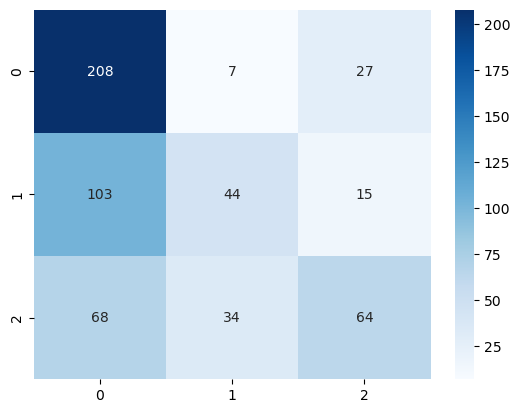

In [33]:
cm = confusion_matrix(hard_df["label"], hard_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')